In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl as xl
import os

import warnings
warnings.filterwarnings('ignore')

## CIFAR

In [2]:
from typing import List

def find_file(names: List[str], n):
    for i in names:
        if i.startswith(str(n)):
            return i
    return None
        
def check_result_existance(folder, experiment):
    full_path = os.path.join(folder, experiment)
    if not [f for f in os.listdir(full_path) if f.endswith('xlsx')]:
        return False
    return True

folder = '../results/ResNet18/CIFAR10/'

true_ops = ['low_rank', 'pruning', 'quant_dynamic', 'quant_static', 'quant_qat']
experiments = [f for f in os.listdir(folder) if f != '.DS_Store']

final_df = pd.DataFrame()
final_comput = {}

for exp in experiments:
    step_dict = {}

    if not check_result_existance(folder, exp):
        continue

    words = exp.split('_')
    words = [w.replace('-', '_') for w in words]

    sequences = []
    operation = []
    for word in words:
        operation.append(word)
        current_op = '_'.join(operation)
        
        if current_op in true_ops:
            sequences.append(current_op)
            operation = []
        elif word in true_ops:
            sequences.append(word)
            operation = []
            
    for ind, oper in enumerate(sequences):
        step_dict[f'op_{ind}'] = oper


    seq = exp
    files = os.listdir(folder + seq)

    xlsx = [f for f in files if f.endswith('xlsx')]

    metric_dict = {}
    comp_dict = {}

    for step in range(4):
        step_result_file = find_file(xlsx, step)

        if step_result_file is None:
            continue

        xls = pd.ExcelFile(folder + seq + '/' + step_result_file)
        quality = pd.read_excel(xls, 'quality_comparison')
        quality.columns = quality.iloc[0]
        quality = quality.drop(quality.index[0])
        

        computational = pd.read_excel(xls, 'computational_comparison')
        if step == 0:

            init_f1 = quality[quality['mode'] == 'f1']['original'].values[0]
            latency_init, size_init, thr_init = computational.iloc[2, 1], computational.iloc[3, 1], computational.iloc[4, 1]
            comp_dict['init'] = {
                'latency': latency_init,
                'size': size_init,
                'throughput': thr_init
            }
            metric_dict['init_f1'] = init_f1
            

        step_f1 = quality[quality['mode'] == 'f1']['fedcore'].values[0]
        latency_step, size_step, thr_step = computational.iloc[2, 2], computational.iloc[3, 2], computational.iloc[4, 2]
        
        metric_dict[f'step_{step}'] = step_f1
        comp_dict[f'step_{step}'] = {
                'latency': latency_step,
                'size': size_step,
                'throughput': thr_step
            }
    
    final_comput[f'{exp}'] = comp_dict


    metric_df = pd.DataFrame(metric_dict, index=[0])
    steps_df = pd.DataFrame(step_dict, index=[0])
    final_exp_df = pd.concat([steps_df, metric_df], axis=1)

    final_df = pd.concat([final_df, final_exp_df], axis=0).reset_index(drop=True)

    # FORWARDD FILL FOR SKIPPED STEPS AND DROP PIPELINES WHERE NO INIT VALUE
    # numerical_cols = final_df.select_dtypes(include=['int64', 'float64']).columns
    # final_df[numerical_cols] = final_df[numerical_cols].fillna(method='ffill', axis=1).dropna(axis=0).reset_index(drop=True)

data = final_df.copy()
data.columns = data.columns.str.strip()
for col in ['init_f1', 'step_0', 'step_1', 'step_2', 'step_3']:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# rows with missing step_3 for final comparison
data_step3 = data.copy()
data_step3 = data.dropna(subset=['step_3'])
data_step3['combination'] = data_step3[['op_0', 'op_1', 'op_2', 'op_3']].agg(' → '.join, axis=1)

top_combinations = data_step3[['combination', 'init_f1', 'step_3']].sort_values(by='step_3', ascending=False)

print("\nTop 5 Combinations by step_3 F1 Score:")
print(top_combinations.head(5).to_string(index=False))



Top 5 Combinations by step_3 F1 Score:
                                      combination  init_f1  step_3
   low_rank → quant_dynamic → pruning → quant_qat    0.759   0.702
   low_rank → quant_qat → pruning → quant_dynamic    0.759   0.663
    low_rank → quant_static → pruning → quant_qat    0.759   0.660
low_rank → quant_static → pruning → quant_dynamic    0.759   0.656


In [3]:
final_df

,op_0,op_1,op_2,op_3,init_f1,step_0,step_1,step_2,step_3
0,low_rank,quant_static,pruning,quant_qat,0.759,0.722,0.722,0.660,0.660
1,low_rank,quant_dynamic,pruning,quant_static,0.759,0.712,0.712,NaN,NaN
2,low_rank,quant_dynamic,pruning,quant_qat,0.759,0.702,0.702,NaN,0.702
3,low_rank,quant_qat,pruning,quant_dynamic,0.759,0.716,0.716,0.663,0.663
4,low_rank,quant_static,pruning,quant_dynamic,0.759,0.717,0.717,0.656,0.656
5,low_rank,quant_qat,pruning,quant_static,0.759,0.699,0.699,0.277,NaN


In [4]:
best_comb = top_combinations.combination[0].replace('_', '-').replace(' → ', '_')
ops = best_comb.split('_')

best_comb

'low-rank_quant-static_pruning_quant-qat'

In [5]:
pd.DataFrame(final_comput[best_comb])

,init,step_0,step_1,step_2,step_3
latency,1.413557,2.218028,2.196728,1.95003,1.900731
size,42.655000,43.349000,43.349000,10.85400,10.854000
throughput,22.639028,15.283861,14.923411,16.82483,17.122877


<Axes: >

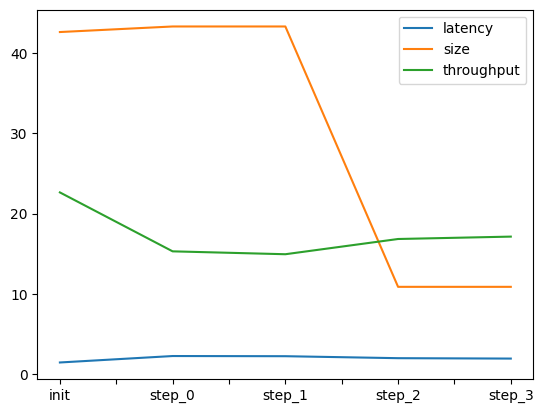

In [6]:
pd.DataFrame(final_comput[best_comb]).T.plot()


Trend Slopes:
low-rank_quant-static_pruning_quant-qat_latency_slope: -0.1199
low-rank_quant-static_pruning_quant-qat_size_slope: -12.9980
low-rank_quant-static_pruning_quant-qat_throughput_slope: 0.7418
low-rank_quant-dynamic_pruning_quant-static_latency_slope: -0.0304
low-rank_quant-dynamic_pruning_quant-static_size_slope: -0.0000
low-rank_quant-dynamic_pruning_quant-static_throughput_slope: 0.2999
low-rank_quant-dynamic_pruning_quant-qat_latency_slope: 0.1421
low-rank_quant-dynamic_pruning_quant-qat_size_slope: 0.0000
low-rank_quant-dynamic_pruning_quant-qat_throughput_slope: -0.8316
low-rank_quant-qat_pruning_quant-dynamic_latency_slope: -0.1144
low-rank_quant-qat_pruning_quant-dynamic_size_slope: -12.9980
low-rank_quant-qat_pruning_quant-dynamic_throughput_slope: 0.8403
low-rank_quant-static_pruning_quant-dynamic_latency_slope: -0.1301
low-rank_quant-static_pruning_quant-dynamic_size_slope: -13.0068
low-rank_quant-static_pruning_quant-dynamic_throughput_slope: 0.9802
low-rank_quan

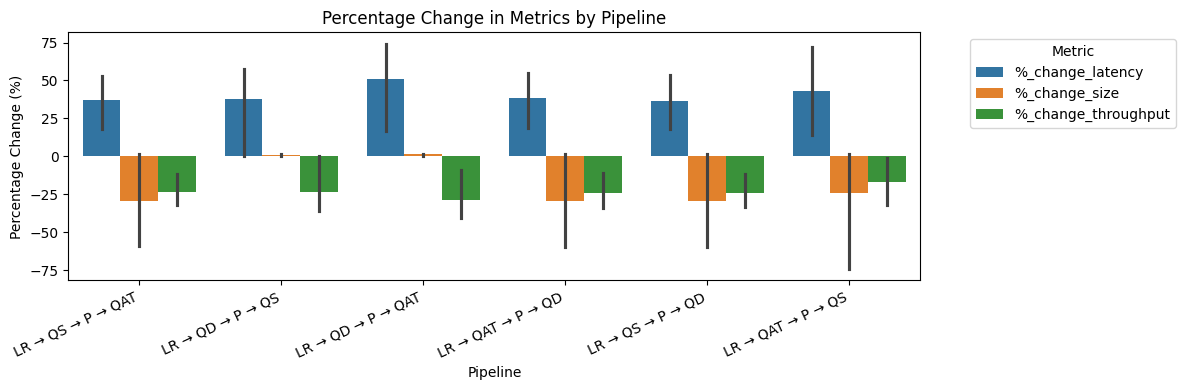

In [7]:
import seaborn as sns

data = final_comput
# low-rank_quant-static_pruning_quant-qat
rows = []
mapping = {
    'low-rank': 'LR',
    'quant-static': 'QS',
    'pruning': 'P',
    'quant-qat': 'QAT',
    'quant-dynamic': 'QD'
}

for pipeline, steps in data.items():
    for key, value in mapping.items():
        pipeline = pipeline.replace(key, value)
    
    pipeline = pipeline.replace('_', ' → ')

    for step, metrics in steps.items():
        rows.append({'pipeline': pipeline, 'step': step, **metrics})
df = pd.DataFrame(rows)


def calc_percent_change(group, metric):
    init_val = group[group['step'] == 'init'][metric].iloc[0]
    return ((group[metric] - init_val) / init_val * 100).round(2)

for metric in ['latency', 'size', 'throughput']:
    df[f'%_change_{metric}'] = df.groupby('pipeline').apply(lambda x: calc_percent_change(x, metric)).reset_index(level=0, drop=True)


summary_stats = df.groupby(['pipeline', 'step']).agg({
    'latency': ['mean', 'std'],
    'size': ['mean', 'std'],
    'throughput': ['mean', 'std'],
    f'%_change_latency': 'mean',
    f'%_change_size': 'mean',
    f'%_change_throughput': 'mean'
}).round(3)

trends = {}
for pipeline in data.keys():
    steps = [s for s in data[pipeline].keys() if s != 'init']
    step_indices = range(len(steps))
    for metric in ['latency', 'size', 'throughput']:
        values = [data[pipeline][s][metric] for s in steps]
        coeffs = np.polyfit(step_indices, values, 1)
        trends[f"{pipeline}_{metric}_slope"] = coeffs[0]
print("\nTrend Slopes:")
for key, value in trends.items():
    print(f"{key}: {value:.4f}")

melted_df = df.melt(id_vars=['pipeline', 'step'], 
                    value_vars=[f'%_change_{m}' for m in ['latency', 'size', 'throughput']],
                    var_name='metric', value_name='percent_change')
plt.figure(figsize=(12, 4))
sns.barplot(data=melted_df, x='pipeline', hue='metric', y='percent_change')
plt.title('Percentage Change in Metrics by Pipeline')
plt.xlabel('Pipeline')
plt.ylabel('Percentage Change (%)')
plt.xticks(rotation=25, ha='right')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()

plt.show()